## Bayesian optimization to infer Fractional Maxwell Liquid fitting parameters for the stress relaxation of shaving foam 

First, we are importing a variety of essential libraries that will help us with numerical computations, data manipulation, plotting, machine learning, Bayesian optimization, and other specialized tasks.

### Libraries:
- **NumPy (`numpy`)**: A fundamental package for numerical operations in Python.
- **Pandas (`pandas`)**: A powerful data manipulation and analysis library.
- **Matplotlib (`matplotlib.pyplot`)**: A plotting library used for creating static, animated, and interactive visualizations.
- **SciPy Special Functions (`scipy.special`)**: Specifically importing the gamma function for mathematical computations.
- **PyTorch (`torch`)**: A deep learning library for tensor computations and building neural networks.
- **BoTorch and GPyTorch**: Libraries for Gaussian Process Regression:
  - `SingleTaskGP`: For constructing Gaussian Process models.
  - `Standardize`: For standardizing outcomes.
  - `ExactMarginalLogLikelihood`: For exact marginal log likelihood calculation.
  - `fit_gpytorch_mll`: For fitting GP models.
- **Sobol Sequence (`sobol_seq`)**: For generating Sobol sequences for quasi-random sampling.
- **BoTorch Acquisition and Optimization**:
  - `qExpectedImprovement`: For Monte Carlo-based expected improvement.
  - `optimize_acqf`: For optimizing the acquisition function.
- **Scikit-Learn Preprocessing (`sklearn.preprocessing`)**: A collection of scalers for feature scaling, including:
  - `MinMaxScaler`
  - `RobustScaler`
  - `StandardScaler`
  - `MaxAbsScaler`
- **pyRheo (`pyRheo.relaxation_evaluator`)**: A custom library for evaluating relaxation properties.
- **SciencePlots (`scienceplots`)**: A library to enhance Matplotlib plots with scientific visual styles.

These imports will provide all the necessary tools for the subsequent analysis and model building steps in this notebook.


In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize, least_squares
import torch
import time as timer
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
import sobol_seq
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.logei import qLogExpectedImprovement, qLogNoisyExpectedImprovement
from botorch.acquisition.analytic import LogExpectedImprovement, LogProbabilityOfImprovement
from botorch.optim.optimize import optimize_acqf
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler
from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel, LinearKernel, RQKernel
from gpytorch.constraints import Interval
from pyRheo.relaxation_evaluator import RelaxationEvaluator
import scienceplots
plt.style.use(['science', 'nature', 'retro'])

## Random Error Generation, Objective Function, Sobol Sampling and Model Initialization

In this section, we define various key functions and setup procedures required for our model analysis and optimization:



In [2]:
##### Error function (optional noise injection, default off)
def createRandomError(n, std):
    return np.random.normal(loc=1, scale=std, size=n)

# Objective function to minimize (RRS weighted by true values)
def objective(params):
    logG, logeta, beta = params
    G = 10 ** logG
    eta = 10 ** logeta
    params_no_scale = G, eta, beta
    model = "FractionalMaxwellLiquid"
    evaluator = RelaxationEvaluator(model=model)
    # Compute relaxation
    model_values = evaluator.compute_model(params_no_scale, time, mittag_leffler_type="Pade72") 
    # Add noise
    error = createRandomError(time.shape[0], 0.00)
    model_values_noisy = np.multiply(model_values, error)
    # Define objective functions
    obj1 = np.sum(((y_true - model_values_noisy) / y_true) ** 2)
    return -np.log10(obj1) # we take the negative because the EI by default maximizes and we are looking to minimize


# Function to create Sobol samples
def sobol_sample(space, n_samples):
    sobol_samples = sobol_seq.i4_sobol_generate(len(space), n_samples)
    sobol_scaled = sobol_samples * (space[:, 1] - space[:, 0]) + space[:, 0]
    return np.array(sobol_scaled)


# Initialize model function for single-objective problem
def initialize_model(train_x, train_obj):
    train_obj = train_obj.unsqueeze(-1)  # Add dimension for single task GP
    model = SingleTaskGP(
        train_x, train_obj,
        covar_module= ScaleKernel(
            MaternKernel(
                nu=1.5,
                #ard_num_dims=10,
                has_lengthscale=True,
                #lengthscale_constraint=Interval(0.001, 10),
                outcome_transform=None,
                train_Yvar=None
            )
        )
    )
    
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model


# Compute the qEI acquisition function to find new candidate points that maximize the objective
def compute_qei_acquisition_function(model, train_y, bounds, q_batch_size):
    acq_func = qLogExpectedImprovement(
        model=model,
        best_f=train_y.max(),  # since we're maximizing the negative of the objective error
        #maximize=True
    )
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=q_batch_size,
        num_restarts=1,
        raw_samples=200,
        options={"batch_limit": 5},
        sequential=True # Recommend to use True when the batch is higher than 5.
    )
    return candidates


## Loading Rheological Data and Defining Search Space

In this section, we load the rheological data from a CSV file and define the search space bounds for our parameter optimization.

In [3]:
import pandas as pd
import numpy as np

# -------------------------------
# Load stress relaxation data
# -------------------------------
data = pd.read_csv(
    './data/shaving_foam/stressrelaxation_liquidfoam_data.csv',
    delimiter='\t',
    decimal="."
)

# Extract columns
time_raw = data['Time'].values
y_raw = data['Relaxation Modulus'].values

# -------------------------------
# Downsample to be roughly uniform in log-time because crrent data is very noisy at the end and intriduces artifial weightings
# -------------------------------
n_bins = 200  # number of bins
log_time = np.log10(time_raw)
bins = np.linspace(log_time.min(), log_time.max(), n_bins + 1)
bin_indices = np.digitize(log_time, bins)

# Prepare lists for downsampled data
time_ds = []
y_ds = []

for i in range(1, n_bins + 1):
    mask = bin_indices == i
    if np.any(mask):
        time_ds.append(np.mean(time_raw[mask]))
        y_ds.append(np.mean(y_raw[mask]))

# Overwrite original variables with downsampled data
time = np.array(time_ds)
y_true = np.array(y_ds)


# Define search space bounds
param_space = np.array([
    [1, 3],  # log10 scale for G
    [4, 6],  # log10 scale for V
    [0.1, 0.9]   # real scale for beta
])

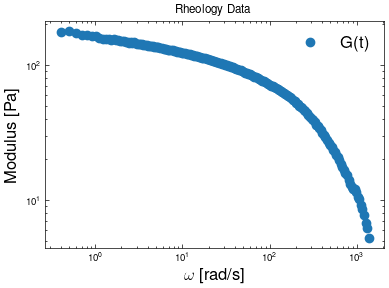

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))

# Plot Storage and Loss modulus
plt.plot(time, y_true, 'o', markersize=6, color='#1f77b4', label="G(t)")

# Log-log axes
plt.xscale('log')
plt.yscale('log')

# Labels and legend
plt.xlabel('$\\omega$ [rad/s]', fontsize=12)
plt.ylabel('Modulus [Pa]', fontsize=12)
plt.legend(fontsize=12)

plt.title("Rheology Data")
plt.tight_layout()
plt.show()


## Initial Sampling, Scaling, and Model Initialization

In this section, we conduct the initial exploration phase of our optimization process.


## Acquisition and Model Updating

In this section, we perform the exploitation phase of our optimization process. We iteratively generate new samples using the q-Expected Improvement (qEI) acquisition function, evaluate the objective function at these new sample points, and update our model accordingly.

### Iterative Optimization Process

For each iteration in the exploitation phase:
1. **Generate New Candidates**: We compute new candidate points using the qEI acquisition function.
2. **Evaluate Objective**: The objective function is evaluated at the new candidate points.
3. **Apply Scaling**: The new objective values are scaled using the previously defined MaxAbsScaler.
4. **Update Samples and Objectives**: The new sample and corresponding objective values (both original and scaled) are appended to the existing lists of samples and objective values. We also save the index of the new sample for tracking purposes.
5. **Update Tensors**: The updated samples and objective values are converted to tensors.
6. **Model Update**: The GP model is re-initialized and fitted using the updated data.
7. **Logging**: The iteration details, including the new sample and objective value, are printed.


In [5]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available?:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.get_device_name(0))


PyTorch version: 2.1.0
CUDA available?: True
Number of GPUs: 1
Current GPU: NVIDIA RTX A2000 12GB


In [6]:
import warnings
import time as timer
import torch
import numpy as np
from botorch.models.utils.assorted import InputDataWarning

warnings.filterwarnings("ignore", category=InputDataWarning)
device_choice = 'cpu'
device = torch.device(device_choice)
print("Using device:", device)


# --- Objective wrapper for Bayesian Optimization ---
def objective_bo_wrapper(x):
    return objective(x)

# --- BO Loop Parameters ---
results = []
best_model = None
best_objective_value_overall = float('-inf')
best_X_samples = None
best_y_samples = None
max_y_per_iteration = []

n_runs = 1
n_initial_points = 8
n_exploitation_iter = 500
no_improvement_limit = 20
tolerance = 1e-2
q_batch_size = 2

# --- BO Loop ---
for run in range(n_runs):
    print(f"\nRun {run + 1}/{n_runs}")

    # Initial Sobol sampling
    X_samples = sobol_sample(param_space, n_initial_points)
    y_samples = np.array([objective_bo_wrapper(x) for x in X_samples])

    X_samples_tensor = torch.tensor(X_samples, dtype=torch.double, device=device)
    y_samples_tensor = torch.tensor(y_samples, dtype=torch.double, device=device)

    bounds = torch.stack([
        torch.tensor(param_space[:, 0], dtype=torch.double, device=device),
        torch.tensor(param_space[:, 1], dtype=torch.double, device=device)
    ])

    print("Initial X_samples shape:", X_samples.shape)
    print("Initial y_samples shape:", y_samples.shape)

    # Initialize and train GP
    mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
    model = model.to(device)
    fit_gpytorch_mll(mll)

    # Exploitation loop
    objective_values = list(y_samples)
    times_per_iteration = []
    cumulative_time = 0
    best_objective_value_run = float('-inf')       # used for tolerance logic
    true_best_objective_value_run = float('-inf')  # always updated
    no_improvement_counter = 0

    for i in range(n_exploitation_iter):
        torch.manual_seed(42 + i)
        np.random.seed(42 + i)

        new_candidates = compute_qei_acquisition_function(
            model, y_samples_tensor, bounds, q_batch_size=q_batch_size
        )
        new_batch = new_candidates.detach().cpu().numpy()
        new_batch_y = [objective_bo_wrapper(x) for x in new_batch]

        X_samples = np.vstack([X_samples, new_batch])
        y_samples = np.append(y_samples, new_batch_y)
        X_samples_tensor = torch.tensor(X_samples, dtype=torch.double, device=device)
        y_samples_tensor = torch.tensor(y_samples, dtype=torch.double, device=device)
        objective_values.extend(new_batch_y)
        max_y_per_iteration.append(y_samples_tensor.max().cpu().numpy())

        start_time = timer.time()
        mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
        model = model.to(device)
        fit_gpytorch_mll(mll)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        iteration_time = timer.time() - start_time
        times_per_iteration.append(iteration_time)
        cumulative_time += iteration_time

        print(f"Exploitation {i + 1}/{n_exploitation_iter} - Batch values: {new_batch_y}")

        batch_best = max(new_batch_y)

        # Always track the true best (for reporting at the end)
        if batch_best > true_best_objective_value_run:
            true_best_objective_value_run = batch_best

        # Keep tolerance-based logic for early stopping
        improvement = batch_best - best_objective_value_run
        if improvement > tolerance:
            best_objective_value_run = batch_best
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= no_improvement_limit:
            print(f"Stopping early due to no significant improvement in the last {no_improvement_limit} iterations.")
            break

    if best_objective_value_run > best_objective_value_overall:
        best_objective_value_overall = best_objective_value_run
        best_model = model
        best_X_samples = X_samples
        best_y_samples = y_samples

    results.append({
        'objective_values': objective_values,
        'times_per_iteration': times_per_iteration,
        'cumulative_time': cumulative_time,
        'best_objective_value_run': true_best_objective_value_run  # ✅ use the true best
    })


# --- Print summary ---
for idx, res in enumerate(results):
    print(f"\nResults from Run {idx + 1}:")
    print("Objective values:", res['objective_values'])
    print("Best objective value in this run:", res['best_objective_value_run'])
    print("Total cumulative time:", res['cumulative_time'])

print("\nOverall best objective value:", best_objective_value_overall)
if best_model:
    print("Best X_samples from the best run:", best_X_samples)
    print("Best y_samples from the best run:", best_y_samples)
else:
    print("No best model found")

max_y_per_iteration = np.array(max_y_per_iteration)


Using device: cpu

Run 1/1
Initial X_samples shape: (8, 3)
Initial y_samples shape: (8,)
Exploitation 1/500 - Batch values: [-1.759320386344061, -2.207064652055217]
Exploitation 2/500 - Batch values: [-2.362670578449274, -1.8582635552452842]
Exploitation 3/500 - Batch values: [-1.546405723205448, -1.2843449780785454]
Exploitation 4/500 - Batch values: [-0.8778705852491502, -1.511036648953237]
Exploitation 5/500 - Batch values: [0.18763209501043585, -0.6450008865468166]
Exploitation 6/500 - Batch values: [-1.1586220981944324, -1.4133671180256293]
Exploitation 7/500 - Batch values: [-1.3767783955602555, -1.9201934941936565]
Exploitation 8/500 - Batch values: [0.4530983195865353, -0.48533741191314883]
Exploitation 9/500 - Batch values: [0.2819025498446692, -0.43389588393585765]
Exploitation 10/500 - Batch values: [-0.8401133145712818, 0.457464614630115]
Exploitation 11/500 - Batch values: [0.6068366515541539, -0.9221914120676067]
Exploitation 12/500 - Batch values: [0.19759909135301312, -

## Visualizing Optimization Progress

In this section, we plot the negative of the objective function values as a function of the number of iterations. This helps us visually assess the optimization progress and the performance of the Sobol and Expected Improvement (EI) sampling strategies.

### Steps Involved in the Plotting Process:

1. **Configure the Plot**:
   We set the figure size and layout for constrained layout setting for better spacing.
   
2. **Prepare Data for Plotting**:
   - We create an array representing the iterations.
   - We negate the objective function values (`neg_objective_values`) because we are minimizing the objective, and lower values represent better performance.

3. **Plot the Sobol and EI Samples**:
   - Plot the initial Sobol samples in one color (`#89BFA9`), marking them as 'Sobol'.
   - Plot the subsequent EI samples in another color (`#60568A`), marking them as 'EI'.

4. **Customize Plot Appearance**:
   - Set the limits for the x-axis.
   - Label the x-axis as the number of iterations (`$n$`).
   - Label the y-axis as the log of the Residual Sum of Squares (RSS) weighted by true values (`$\\log$ RSS$_{w_{i}}$`).
   - Customize the font size of axis labels and tick labels.
   - Add a legend to distinguish between Sobol and EI samples.
  
5. **Display the Plot**:
   - Show the plot using `plt.show()`.
   
6. **Print the Minimum Objective Value**:
   - Print the minimum value of the negated objective values to see the best objective value achieved during the optimization process.


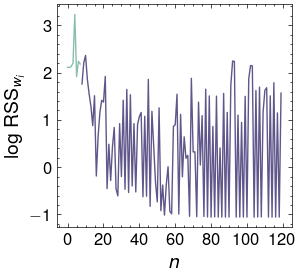

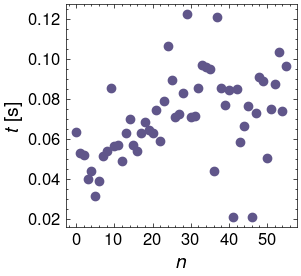

Run 1: The minimum value of the objective function in log10 scale is -1.0567
Run 1: Cumulative time for all iterations: 3.9204 seconds


In [7]:
# Prepare the figure for Objective Values
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)

# Iterate over results from each run and plot
for idx, res in enumerate(results):
    objective_values = res['objective_values']
    iterations = np.arange(len(objective_values))
    neg_objective_values = -np.array(objective_values)

    # Plot initial Sobol samples
    plt.plot(
        iterations[:n_initial_points],
        neg_objective_values[:n_initial_points],
        '-', 
        markersize=6, 
        label=f'Run {idx+1} Sobol',
        color='#89BFA9'
    )

    # Plot EI samples
    plt.plot(
        iterations[n_initial_points:], 
        neg_objective_values[n_initial_points:], 
        '-', 
        markersize=6,
        label=f'Run {idx+1} logEI',
        color='#60568A'
    )

# Customize Plot Appearance
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$\\log$ RSS$_{w_{i}}$', fontsize=14)           # Y-axis label
plt.xticks(fontsize=12)                                   # X-axis tick label size
plt.yticks(fontsize=12)                                   # Y-axis tick label size
#plt.legend(fontsize=10, loc="best")                       # Display legend

# Display or Save the Plot
plt.savefig("combined_fig_ei_oscillation_chia.pdf")
plt.show()

# Prepare the figure for Time per Iteration
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)

# Iterate over results from each run and plot time per iteration
for idx, res in enumerate(results):
    times_per_iteration = res['times_per_iteration']
    iterations = np.arange(len(times_per_iteration))

    plt.plot(
        iterations[:len(times_per_iteration)], 
        times_per_iteration, 
        'o', 
        markersize=6, 
        label=f'Run {idx+1} Time', 
        color='#60568A'
    )

# Customize Plot Appearance
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$t$ [s]', fontsize=14)                        # Y-axis label
plt.xticks(fontsize=12)                                   # X-axis tick label size
plt.yticks(fontsize=12)                                   # Y-axis tick label size
#plt.legend(fontsize=10, loc="best")                       # Display legend

# Display or Save the Time Plot
plt.savefig("combined_fig_time_per_iteration.pdf")
plt.show()

# Print Minimum Objective Values and Cumulative Time for Each Run
for idx, res in enumerate(results):
    neg_objective_values = -np.array(res['objective_values'])
    cumulative_time = res['cumulative_time']
    print(f"Run {idx + 1}: The minimum value of the objective function in log10 scale is {np.min(neg_objective_values):.4f}")
    print(f"Run {idx + 1}: Cumulative time for all iterations: {cumulative_time:.4f} seconds")


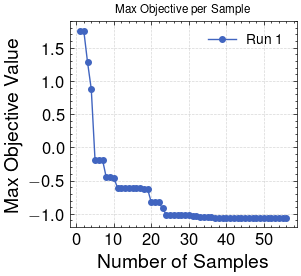

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# Plot Max Objective per Sample (from results)
# ------------------------------
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)

for idx, res in enumerate(results):
    max_y = max_y_per_iteration  # NumPy array with max y per sample
    num_samples = np.arange(1, len(max_y) + 1)  # x-axis = total samples evaluated
    
    plt.plot(
        num_samples,
        -max_y,  # Negate if your objective is minimization
        '-o',
        markersize=4,
        label=f'Run {idx+1}',
        color=f'C{idx}'  # automatic color cycle
    )

# Customize plot
plt.xlabel('Number of Samples', fontsize=14)
plt.ylabel('Max Objective Value', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10, loc="best")
plt.title('Max Objective per Sample')
plt.grid(True, linestyle='--', alpha=0.5)

# Save and show
plt.savefig("max_objective_per_sample.pdf")
plt.show()

## Fitting and Visualizing the Model with Best Parameters from Bayesian Optimization

In this section, we:
1. Define the fractional model evaluator.
2. Extract and print the best parameters obtained from the Bayesian Optimization (BO) phase.
3. Fit the model using the best parameters and compute the model values.
4. Calculate the Residual Sum of Squares (RSS) for the fitted model.
5. Plot the original data, the fitted model from Bayesian Optimization, and the optimized model.


Best parameters from Bayesian Optimization: G = 181.34, eta = 44159.08, beta = 0.12
RSS_w for the Bayesian Optimization model: 0.08777


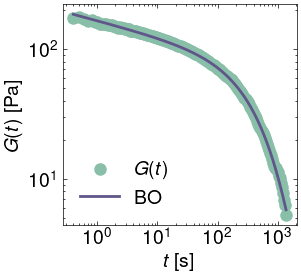

In [9]:
from cycler import cycler  # Import the cycler for customizing plot cycles

# Define model evaluator
fractional_model_name = "FractionalMaxwellLiquid"
evaluator = RelaxationEvaluator(model=fractional_model_name)

# Extract the best parameters from Bayesian Optimization phase
best_idx = np.argmax(best_y_samples)
best_params = best_X_samples[best_idx]
logG_best, logeta_best, beta_best = best_params
G_best_bo = 10 ** logG_best
eta_best_bo = 10 ** logeta_best

# Print the best parameters from Bayesian Optimization
print("Best parameters from Bayesian Optimization: G = {:.2f}, eta = {:.2f}, beta = {:.2f}".format(G_best_bo, eta_best_bo, beta_best))

# Fit the model with the best parameters from Bayesian Optimization
best_params_no_scale = G_best_bo, eta_best_bo, beta_best
bo_model_values = evaluator.compute_model(best_params_no_scale, time, mittag_leffler_type="Pade72")

# Compute the RSS for the Bayesian Optimization model
rss_bo = np.sum(((y_true - bo_model_values) / y_true) ** 2)
print(f"RSS_w for the Bayesian Optimization model: {rss_bo:.5f}")

# Get the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the data, the fitted model from Bayesian Optimization, and the final optimized model
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)
plt.plot(time, y_true, 'o', markersize=8, color='#89BFA9', label='$G(t)$')  # Original data
plt.plot(time, bo_model_values, '-', color='#60568A', lw=2, label='BO')   # BO model fit
#plt.plot(time, optimal_model_values, '-', color=colors[1], lw=2, label='L-BFGS-B')  # Uncomment to plot optimized model values

# Configure the plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t$ [s]', fontsize=14)
plt.ylabel(r'$G(t)$ [Pa]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="lower left")

# Display the plot
plt.savefig("fig_bo_fit_relaxation_data_liquidfoam.pdf")  # Uncomment to save the plot
plt.show()

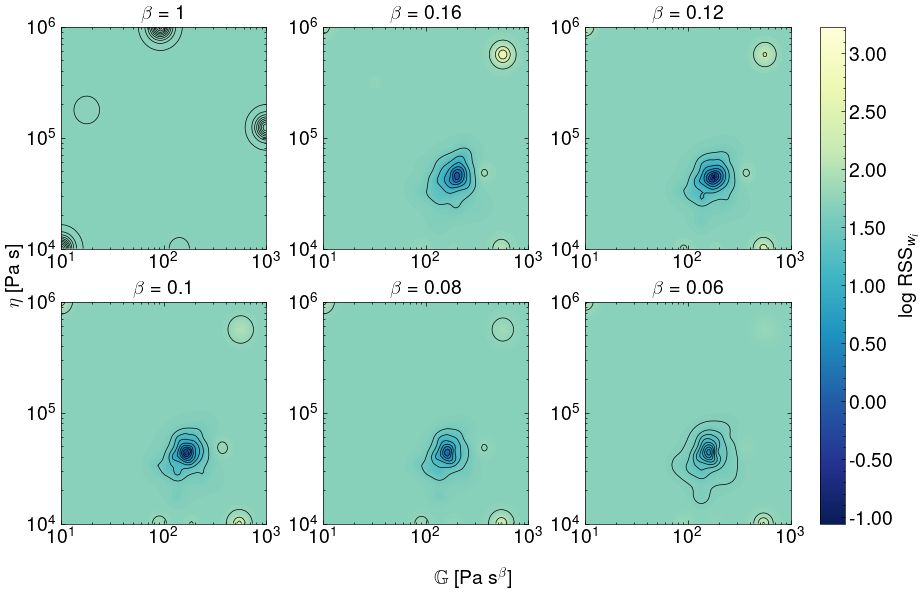

In [10]:
import matplotlib.colors as mcolors

def predict_model_on_grid_2D(model, param_space, beta_value, resolution=100):
    """
    Predict the model outputs on a 2D grid over logG and log_eta with a fixed beta value.
    """
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    beta_grid = torch.full_like(logG_grid, beta_value)  # Keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_1 = model.posterior(param_grid).mean.numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_1

# Define specific beta values to plot
beta_values = [1, 0.16, 0.12, 0.10, 0.08, 0.06]
resolution = 100

# Ensure these values are correctly calculated
min_val, max_val = (-max(objective_values), -min(objective_values))

# Create subplots for each beta value
fig, axes = plt.subplots(2, 3, figsize=(9, 5.5), constrained_layout=True)
contours_list = []
global_minima = []  # To store global minima parameters

for ax, beta in zip(axes.flatten(), beta_values):
    logG_grid, logV_grid, preds_obj1 = predict_model_on_grid_2D(model, param_space, beta, resolution)
    
    # Convert logG and logV to G and V
    G = 10 ** logG_grid.numpy()
    V = 10 ** logV_grid.numpy()

    # Take negative predictions because of the sign inversion
    neg_preds_obj1 = -1 * preds_obj1
    
    # Find global minima
    min_index = np.unravel_index(neg_preds_obj1.argmin(), neg_preds_obj1.shape)
    global_min_logG = logG_grid[min_index]
    global_min_logV = logV_grid[min_index]
    global_min_G = 10 ** global_min_logG
    global_min_V = 10 ** global_min_logV
    global_min_value = neg_preds_obj1[min_index]
    global_minima.append((global_min_G.item(), global_min_V.item(), 10 ** global_min_value))
    
    # Create the 2D contour plot
    contour = ax.contourf(G, V, neg_preds_obj1, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
    contours_list.append(contour)
    ax.contour(G, V, neg_preds_obj1, levels=10, colors='black', linewidths=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(f'$\\beta$ = {beta}', fontsize=14)

# Create a ScalarMappable for the colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Add a single colorbar for all subplots
cbar = fig.colorbar(sm, ax=axes, location='right', aspect=20, pad=0.02, format='%.2f')
cbar.set_label('$\\log$ RSS$_{w_{i}}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Add common labels
fig.text(0.5, -0.05, '$\mathbb{G}$ [Pa s$^{\\beta}$]', ha='center', va='center', fontsize=14)
fig.text(-0.01, 0.5, '$\eta$ [Pa s]', ha='center', va='center', rotation='vertical', fontsize=14)

# Save the plot and show
plt.savefig("fig_obj1_relaxation_liquidfoam.pdf")
plt.show()

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from PIL import Image

# -------------------------------
# Prediction function
# -------------------------------
def predict_model_mean_on_grid_2D(model, param_space, beta_value, resolution=100):
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    beta_grid = torch.full_like(logG_grid, beta_value)

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    with torch.no_grad():
        preds_mean = model.posterior(param_grid).mean.numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_mean

# -------------------------------
# GIF parameters
# -------------------------------
resolution = 100
beta_values = np.arange(1.0, 0.00, -0.01)  # full sweep (1 → 0)
frames = []

# Fix colorbar limits (so consistent across GIF)
# Evaluate at a few betas or precompute global min/max if needed
sample_logG, sample_logV, sample_preds = predict_model_mean_on_grid_2D(best_model, param_space, beta_values[0], resolution)
min_val, max_val = -np.max(sample_preds), -np.min(sample_preds)  # negative for minimization
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
cmap = cm.YlGnBu_r

# -------------------------------
# Loop over beta values
# -------------------------------
for beta in beta_values:
    logG_grid, logV_grid, preds_mean = predict_model_mean_on_grid_2D(best_model, param_space, beta, resolution)
    G = 10 ** logG_grid.numpy()
    V = 10 ** logV_grid.numpy()
    neg_preds = -1 * preds_mean

    fig, ax = plt.subplots(figsize=(3, 2.75), constrained_layout=True)

    # Contour plots
    ax.contourf(G, V, neg_preds, levels=100, vmin=min_val, vmax=max_val, cmap=cmap)
    ax.contour(G, V, neg_preds, levels=10, colors='black', linewidths=0.5)

    # Marker for best BO solution
    ax.plot(G_best_bo, eta_best_bo, "^", color="#FF8C42", ms=10)

    # Axes
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(10, 900)
    ax.set_ylim(10000, 900000)
    ax.set_xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
    ax.set_ylabel('$\eta$ [Pa s]', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Title inside plot
    ax.text(0.5, 0.9, rf'$\beta = {beta:.2f}$', fontsize=14, ha='center', va='center', transform=ax.transAxes)

    # Colorbar at bottom
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, location='bottom', aspect=20, pad=0.05, format='%.2f')
    cbar.set_label('$\log{{\\rm{RSS}}_{w_{i}=y_{i}}}$', fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    # Save frame to memory
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(Image.fromarray(frame))
    plt.close(fig)

# -------------------------------
# Save GIF
# -------------------------------
frames[0].save(
    "optimization_beta_sweep.gif",
    save_all=True,
    append_images=frames[1:],
    duration=300,  # ms per frame
    loop=0
)
print("GIF saved: optimization_beta_sweep.gif")


/tmp/ipykernel_11206/735176775.py:78: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


GIF saved: optimization_beta_sweep.gif


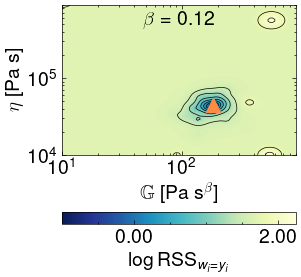

In [12]:
import matplotlib.colors as mcolors

def predict_model_mean_on_grid_2D(model, param_space, beta_value, resolution=100):
    """
    Predict the model outputs on a 2D grid over logG and log_eta with a fixed beta value.
    """
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    beta_grid = torch.full_like(logG_grid, beta_value)  # Keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_mean = model.posterior(param_grid).mean.numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_mean

# Define specific beta values to plot
beta = beta_best
resolution = 100

# Plotting
plt.figure(figsize=(3, 2.75), constrained_layout=True)

logG_grid, logV_grid, preds_obj_mean = predict_model_mean_on_grid_2D(best_model, param_space, beta, resolution)

# Min/Max values for color scaling
min_val, max_val = (-np.max(preds_obj_mean), -np.min(preds_obj_mean))

# Convert logG and logV to G and V
G = 10 ** logG_grid.numpy()
V = 10 ** logV_grid.numpy()

# Inverting predictions
neg_preds_obj_mean = -1 * preds_obj_mean  # Apply your scaler if needed

# 2D contour plot
contour = plt.contourf(G, V, neg_preds_obj_mean, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, neg_preds_obj_mean, levels=10, colors='black', linewidths=0.5)
plt.plot(G_best_bo, eta_best_bo, "^", color="#FF8C42", ms=10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10, 900)
plt.ylim(10000, 900000)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\eta$ [Pa s]', fontsize=14)

# Title inside the plot
plt.text(0.5, 0.9, rf'$\beta = {beta_best:.2f}$', 
         fontsize=14, ha='center', va='center', color='black', 
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Corrected colorbar axis
cbar = plt.colorbar(sm, ax=plt.gca(), location='bottom', aspect=20, pad=0.05, format='%.2f')
cbar.set_label('$\log{{\\rm{RSS}}_{w_{i}=y_{i}}}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Save and display
plt.savefig("fig_obj1_relaxation_liquidfoam_solution_mean.pdf")
plt.show()

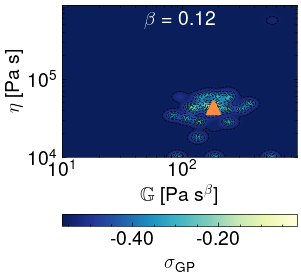

In [13]:
import matplotlib.colors as mcolors

def predict_model_std_on_grid_2D(model, param_space, beta_value, resolution=100):
    """
    Predict the model outputs on a 2D grid over logG and log_eta with a fixed beta value.
    """
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    beta_grid = torch.full_like(logG_grid, beta_value)  # Keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_std = model.posterior(param_grid).variance.sqrt().numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_std

# Define specific beta values to plot
beta = beta_best
resolution = 100

# Plotting
plt.figure(figsize=(3, 2.75), constrained_layout=True)

logG_grid, logV_grid, preds_obj_std = predict_model_std_on_grid_2D(best_model, param_space, beta, resolution)

# Min/Max values for color scaling
min_val, max_val = (-np.max(preds_obj_std), -np.min(preds_obj_std))

# Convert logG and logV to G and V
G = 10 ** logG_grid.numpy()
V = 10 ** logV_grid.numpy()

# Inverting predictions
neg_preds_obj_std = -1 * preds_obj_std  # Apply your scaler if needed

# 2D contour plot
contour = plt.contourf(G, V, neg_preds_obj_std, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, neg_preds_obj_std, levels=10, colors='black', linewidths=0.5)
plt.plot(G_best_bo, eta_best_bo, "^", color="#FF8C42", ms=10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10, 900)
plt.ylim(10000, 900000)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\eta$ [Pa s]', fontsize=14)

# Title inside the plot
plt.text(0.5, 0.9, rf'$\beta = {beta_best:.2f}$', 
         fontsize=14, ha='center', va='center', color='white', 
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Corrected colorbar axis
cbar = plt.colorbar(sm, ax=plt.gca(), location='bottom', aspect=20, pad=0.05, format='%.2f')
cbar.set_label('$\sigma_{\\rm{GP}}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Save and display
plt.savefig("fig_obj1_relaxation_liquidfoam_solution_std.pdf")
plt.show()

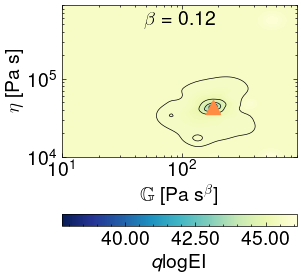

In [14]:
import matplotlib.colors as mcolors

def compute_logei_grid(model, param_space, beta_value, best_f, resolution=100):
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)
    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    beta_grid = torch.full_like(logG_grid, beta_value)

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    acq_func = qLogExpectedImprovement(
        model=model,
        best_f=best_f
    )

    # Reshape for batched qEI input: [N, q=1, d]
    param_grid_q = param_grid.unsqueeze(1)

    with torch.no_grad():
        ei_vals = acq_func(param_grid_q).squeeze().numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, ei_vals


# Define specific beta values to plot
beta = beta_best
resolution = 100
best_f = best_y_samples.max()  # If your objective values are stored in train_y


# Plotting
plt.figure(figsize=(3, 2.75), constrained_layout=True)

logG_grid, logV_grid, preds_obj_mean = compute_logei_grid(best_model, param_space, beta,  best_f, resolution)

# Min/Max values for color scaling
min_val, max_val = (-np.max(preds_obj_mean), -np.min(preds_obj_mean))

# Convert logG and logV to G and V
G = 10 ** logG_grid.numpy()
V = 10 ** logV_grid.numpy()

# Inverting predictions
neg_preds_obj_mean = -1 * preds_obj_mean  # Apply your scaler if needed

# 2D contour plot
contour = plt.contourf(G, V, neg_preds_obj_mean, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, neg_preds_obj_mean, levels=10, colors='black', linewidths=0.5)
plt.plot(G_best_bo, eta_best_bo, "^", color="#FF8C42", ms=10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10, 900)
plt.ylim(10000, 900000)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\eta$ [Pa s]', fontsize=14)

# Title inside the plot
plt.text(0.5, 0.9, r'$\beta = 0.12$', 
         fontsize=14, ha='center', va='center', color='black', 
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Corrected colorbar axis
cbar = plt.colorbar(sm, ax=plt.gca(), location='bottom', aspect=20, pad=0.05, format='%.2f')
cbar.set_label('$q$logEI', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Save and display
plt.savefig("fig_obj1_relaxation_liquidfoam_solution_qei.pdf")
plt.show()

Beta: 0.0, Local Min: 45.308316202613554, Local Max: 45.71897812969963
Beta: 0.12, Local Min: 38.428988983080764, Local Max: 46.13391384436291
Beta: 0.2, Local Min: 44.33184755591457, Local Max: 46.621709936302544
Beta: 0.3, Local Min: 45.21467835275329, Local Max: 46.05699715956154
Global Min: 38.428988983080764, Global Max: 46.621709936302544


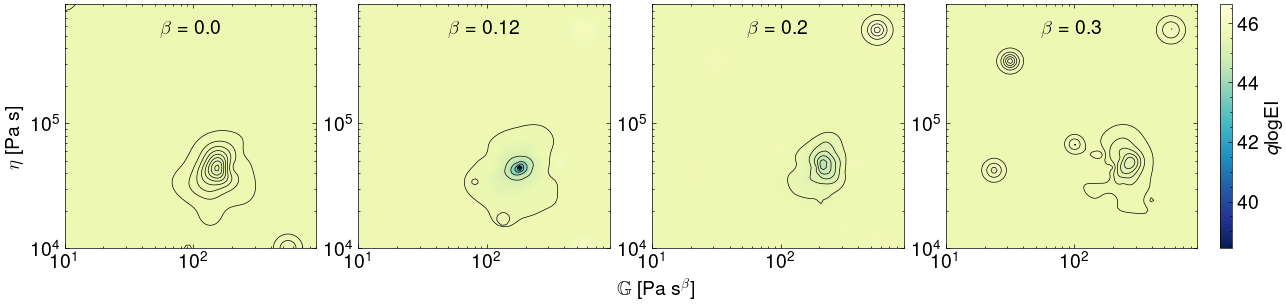

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from botorch.acquisition import qLogExpectedImprovement
import matplotlib.ticker as ticker

def compute_logei_grid(model, param_space, beta_value, best_f, resolution=100):
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)
    
    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    beta_grid = torch.full_like(logG_grid, beta_value)
    
    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)
    
    acq_func = qLogExpectedImprovement(model=model, best_f=best_f)
    
    param_grid_q = param_grid.unsqueeze(1)
    
    with torch.no_grad():
        ei_vals = acq_func(param_grid_q).squeeze().numpy().reshape(logG_grid.shape)
    
    return logG_grid, logV_grid, ei_vals

# Define specific beta values to plot
beta_values = [0.0, 0.12, 0.2, 0.3]
resolution = 100
best_f = best_y_samples.max()  # Assuming your objective values are stored in train_y

# Initialize global min/max for qlogEI values
global_min = float('inf')
global_max = float('-inf')

# Calculate global min/max across all beta values
for beta in beta_values:
    logG_grid, logV_grid, qlogei_vals = compute_logei_grid(best_model, param_space, beta, best_f, resolution)
    local_min = -qlogei_vals.max()
    local_max = -qlogei_vals.min()
    print(f"Beta: {beta}, Local Min: {local_min}, Local Max: {local_max}")
    global_min = min(global_min, local_min)
    global_max = max(global_max, local_max)

print(f"Global Min: {global_min}, Global Max: {global_max}")

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(12.6, 2.75), constrained_layout=True)
norm = mcolors.Normalize(vmin=global_min, vmax=global_max)

for ax, beta in zip(axes.flatten(), beta_values):
    logG_grid, logV_grid, qlogei_vals = compute_logei_grid(best_model, param_space, beta, best_f, resolution)

    qlogei_vals = -1 * qlogei_vals
    
    G = 10 ** logG_grid.numpy()
    V = 10 ** logV_grid.numpy()
    
    # Plot using global min/max to maintain consistent color mapping
    contour = ax.contourf(G, V, qlogei_vals, levels=100, vmin=global_min, vmax=global_max, cmap='YlGnBu_r', norm=norm)
    ax.contour(G, V, qlogei_vals, levels=10, colors='black', linewidths=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(10, 900)     # Set x-axis limits
    ax.set_ylim(10000, 900000)  # Set y-axis limits
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Add beta text inside the plot
    ax.text(0.5, 0.9, f'$\\beta = {beta}$', transform=ax.transAxes, fontsize=14, ha='center', va='center')

sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes, location='right', aspect=20, pad=0.02, format='%d')  # Display values without decimals
cbar.set_label('$q$logEI', fontsize=14)
cbar.ax.tick_params(labelsize=14)

fig.text(0.5, -0.05, '$\mathbb{G}$ [Pa s$^{\\beta}$]', ha='center', va='center', fontsize=14)
fig.text(-0.01, 0.5, '$\eta$ [Pa s]', ha='center', va='center', rotation='vertical', fontsize=14)

plt.savefig("fig_multiple_beta_values_qlogEI.pdf")
plt.show()


In [16]:
# Objective function to minimize (RRS weighted by true values)
def objective_minimize(params, time, y_true):
    logG, logV, beta = params
    G = 10 ** logG
    V = 10 ** logV
    params_no_scale = G, V, beta
    model = "FractionalMaxwellLiquid"
    evaluator = RelaxationEvaluator(model=model)
    
    # Compute oscillation data
    model_values = evaluator.compute_model(params_no_scale, time, mittag_leffler_type="Pade63")
    
    # Add noise
    error = createRandomError(time.shape[0], 0.00)
    model_values_noisy = np.multiply(model_values, error)
    
    # Define objective function: sum of squared relative errors for G' and G''
    obj1 = np.sum(((y_true - model_values_noisy) / y_true) ** 2)
    
    return obj1  # Return the raw error (we no longer need the -log10)

def callback(params):
    obj_value = objective_minimize(params, time, y_true)
    current_errors.append(obj_value)

In [17]:
import numpy as np
from scipy.optimize import minimize
import time as timer
from collections import defaultdict

# -------------------------------
# Custom bounds from param_space
# -------------------------------
custom_bounds = [(low, high) for (low, high) in param_space]
print(custom_bounds)

# -------------------------------
# Initial guesses from Sobol or random points
# -------------------------------
n_initial_guesses = 8
initial_guesses_list = X_samples[:n_initial_guesses].tolist()

# -------------------------------
# Prepare storage
# -------------------------------
results_spy = []
cumulative_times = {method: 0.0 for method in ['L-BFGS-B', 'Nelder-Mead', 'Powell']}
method_paths = defaultdict(list)

# -------------------------------
# List of optimization methods
# -------------------------------
methods = ['L-BFGS-B', 'Nelder-Mead', 'Powell']  # Add others if desired

# -------------------------------
# Start total timing
# -------------------------------
start_time_total = timer.time()

# -------------------------------
# Multi-start optimization with error handling
# -------------------------------
for method in methods:
    print(f"\nRunning optimization with method: {method}")
    method_cumulative = 0.0

    for run_idx, initial_guess in enumerate(initial_guesses_list):
        best_so_far = []

        # Evaluate initial guess before iterations
        init_val = objective_minimize(initial_guess, time, y_true)
        best_so_far.append(init_val)

        # Callback function for tracking progress
        def callback_fn(xk):
            val = objective_minimize(xk, time, y_true)
            # monotone "best so far" tracking
            best_so_far.append(min(val, best_so_far[-1]))


        if method == 'Nelder-Mead':
            options = {'xatol': 1e-9, 'fatol': 1e-9, 'maxfev': 2000, 'disp': True}
        elif method in ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell']:
            options = {'ftol': 1e-9, 'maxiter': 1000, 'disp': True}
        else:
            options = {'maxiter': 1000, 'disp': True}

        # Bounds
        bounds = custom_bounds if method in ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'Nelder-Mead'] else None

        # -------------------------------
        # Time this run
        # -------------------------------
        start_time_iter = timer.time()

        try:
            res = minimize(
                objective_minimize,
                initial_guess,
                args=(time, y_true),
                method=method,
                bounds=bounds,
                callback=callback_fn if method not in ['TNC'] else None,
                options=options
            )

            elapsed_time_iter = timer.time() - start_time_iter
            method_cumulative += elapsed_time_iter

            n_iterations = len(best_so_far)

            # Store results
            results_spy.append({
                'method': method,
                'initial_guess': initial_guess,
                'result': res,
                'time': elapsed_time_iter,
                'path': best_so_far,
                'iterations': n_iterations
            })
            method_paths[(method, run_idx)] = best_so_far

            print(f"Completed initial guess {run_idx+1}/{len(initial_guesses_list)} "
                  f"in {elapsed_time_iter:.4f} s; fun = {res.fun:.6f}; "
                  f"iterations = {n_iterations}")

        except Exception as e:
            elapsed_time_iter = timer.time() - start_time_iter
            print(f"Skipping initial guess {run_idx+1} due to error: {e}")
            continue

    cumulative_times[method] = method_cumulative
    print(f"\nCumulative time for {method}: {method_cumulative:.4f} s")

# -------------------------------
# Total elapsed time
# -------------------------------
total_time = timer.time() - start_time_total
print(f"\nTotal optimization time for all methods: {total_time:.4f} seconds")

# -------------------------------
# Extract function values and optimized parameters
# -------------------------------
function_values = [entry['result'].fun for entry in results_spy]
optimized_parameters = [entry['result'].x for entry in results_spy]
individual_times = [entry['time'] for entry in results_spy]
iteration_counts = [entry['iterations'] for entry in results_spy]

# -------------------------------
# Select best result
# -------------------------------
best_idx = np.argmin(function_values)
best_fun = function_values[best_idx]
best_params = optimized_parameters[best_idx]

print(f"\nBest objective value: {best_fun}")
print(f"Best parameters (logG_i): {best_params}")
print(f"Time for best run: {individual_times[best_idx]:.4f} s")
print(f"Iterations for best run: {iteration_counts[best_idx]}")

# -------------------------------
# Print cumulative times per method
# -------------------------------
print("\nCumulative times per method:")
for method, cum_time in cumulative_times.items():
    print(f"{method}: {cum_time:.4f} s")

# -------------------------------
# Print iteration counts per initial guess
# -------------------------------
print("\nIteration counts per initial guess:")
for idx, entry in enumerate(results_spy):
    print(f"Initial guess {idx+1}: {entry['iterations']} iterations")


[(1.0, 3.0), (4.0, 6.0), (0.1, 0.9)]

Running optimization with method: L-BFGS-B
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29382D+02    |proj g|=  1.00000D+00

At iterate    1    f=  2.78301D+01    |proj g|=  1.38598D+00

At iterate    2    f=  2.57076D+01    |proj g|=  1.41173D+00

At iterate    3    f=  2.54307D+01    |proj g|=  1.41869D+00

At iterate    4    f=  2.46842D+01    |proj g|=  1.43588D+00

At iterate    5    f=  2.41009D+01    |proj g|=  1.50015D+00

At iterate    6    f=  2.39102D+01    |proj g|=  1.43082D+00

At iterate    7    f=  2.38110D+01    |proj g|=  1.41328D+00

At iterate    8    f=  2.37028D+01    |proj g|=  1.38986D+00

At iterate    9    f=  2.33099D+01    |proj g|=  1.29846D+00

At iterate   10    f=  2.26009D+01    |proj g|=  5.06298D-01

At iterate   11    f=  2.17135D+01    |proj g|=  1.02570D+00

At iter

In [18]:
# -------------------------------
print("\nCumulative times per method:")
for method, cum_time in cumulative_times.items():
    print(f"{method}: {cum_time:.4f} s")


Cumulative times per method:
L-BFGS-B: 0.0970 s
Nelder-Mead: 0.2806 s
Powell: 0.3043 s


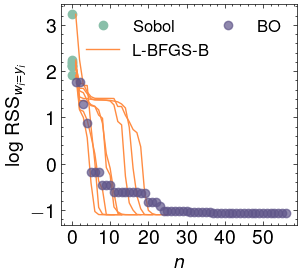

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Define colors for each method
# -------------------------------
colors = {'L-BFGS-B': '#FF8C42', 'Nelder-Mead': '#89BFA9', 'Powell': '#60568A'}

# -------------------------------
# Prepare figure
# -------------------------------
plt.figure(figsize=(3, 2.75), constrained_layout=True)

# Plot initial Sobol samples
plt.plot(
    np.zeros(n_initial_points),
    neg_objective_values[:n_initial_points],
    'o', 
    markersize=6, 
    label='Sobol',
    color='#89BFA9'
    )

# -------------------------------
# Plot optimization paths
# -------------------------------
for method in ['L-BFGS-B']:
    # Filter results for this method
    method_results = [res for res in results_spy if res['method'] == method]

    for idx, res_entry in enumerate(method_results):
        # Use intermediate function values if stored in res_entry['path'], otherwise just final value
        if 'path' in res_entry:
            path_values = np.array(res_entry['path'])
        else:
            path_values = np.array([res_entry['result'].fun])  # fallback to single value

        # Number of iterations
        iterations = np.arange(1, len(path_values) + 1)

        # Plot path
        plt.plot(
            iterations,
            np.log10(path_values),
            '-', 
            markersize=4,
            alpha=1,
            color=colors[method],
            label=method if idx == 0 else ""  # label only first run per method
        )

# -------------------------------
# Optional: overlay Bayesian Optimization iterations
# -------------------------------
objective_values = max_y_per_iteration  # From BO
iterations = np.arange(1, len(objective_values) + 1)
neg_objective_values_bo = -np.array(objective_values)

plt.plot(
    iterations,
    neg_objective_values_bo,
    "o",
    markersize=6, alpha=0.7,
    color='#60568A',
    label='BO'
)



# -------------------------------
# Customize plot
# -------------------------------
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$\\log$ RSS$_{w_{i}=y_{i}}$', fontsize=14)
#plt.xlim(-5, 100)
#plt.ylim(-1, 3.8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=12, loc='upper right', ncols=2, columnspacing=0.1)

# -------------------------------
# Save and display
# -------------------------------
plt.savefig("optimization_paths_vs_iterations_liquidfoam.pdf")
plt.show()


[2.2549587  4.63748857 0.12022477]
{'method': 'L-BFGS-B', 'initial_guess': [2.75, 5.75, 0.2], 'result':   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.0789797989999456
        x: [ 2.255e+00  4.637e+00  1.202e-01]
      nit: 12
      jac: [ 2.179e-07  5.716e-06  6.666e-06]
     nfev: 108
     njev: 27
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>, 'time': 0.011432886123657227, 'path': [1693.937922331743, 175.54086387296127, 49.569542192538705, 49.019596851276575, 6.232984603592062, 1.0714667822586807, 0.11366647590936829, 0.08123164125344887, 0.07905697873171014, 0.07898038398313728, 0.07897980212332067, 0.0789797991060209, 0.0789797989999456], 'iterations': 13}


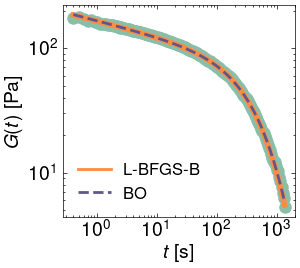

In [20]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

# Choose which method to plot
method_to_plot = 'L-BFGS-B'
method_color = '#FF8C42'  # color for this method
legend_lw = 2

# Create the plot
plt.figure(figsize=(3, 2.75))

# -------------------------------
# Plot experimental data
# -------------------------------
plt.plot(time, y_true, 'o', markersize=8, color='#89BFA9', label="G' (data)")

# -------------------------------
# Plot best result for the selected method
# -------------------------------
method_results = [res for res in results_spy if res['method'] == method_to_plot]
if method_results:
    best_result = min(method_results, key=lambda r: r['result'].fun)
    best_params = best_result['result'].x
    print(best_params)
    print(best_result)
    N_modes = len(best_params)

    G_model = evaluator.compute_model(
        (10**best_params[0], 10**best_params[1], best_params[2]), time
    )
    
    # Plot lines (thick)
    plt.plot(time, G_model, '-', color=method_color, lw=4, label=f"{method_to_plot} fit G'")

# -------------------------------
# Plot BO solution (optional)
# -------------------------------
plt.plot(time, bo_model_values, '--', color='#60568A', lw=2, label='BO')

# -------------------------------
# Configure axes
# -------------------------------
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t$ [s]', fontsize=14)
plt.ylabel(r'$G(t)$ [Pa]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# -------------------------------
# Custom legend
# -------------------------------
handles = [
    mlines.Line2D([], [], color=method_color, lw=legend_lw, label=method_to_plot),
    mlines.Line2D([], [], color='#60568A', lw=legend_lw, linestyle="--", label='BO'),
    #mlines.Line2D([], [], color='#89BFA9', lw=1, marker='o', linestyle='None', label='Data')
]
plt.legend(handles=handles, fontsize=12)

# -------------------------------
# Save and show
# -------------------------------
plt.savefig(f"fig_bo_fit_{method_to_plot}_liquidfoam.pdf")
plt.show()


In [21]:
from scipy.optimize import least_squares

# Objective function to minimize (RRS weighted by true values)
def objective_residuals(params, time, y_true):
    logG, logV, beta = params
    G = 10 ** logG
    V = 10 ** logV
    params_no_scale = G, V, beta
    model = "FractionalMaxwellLiquid"
    evaluator = RelaxationEvaluator(model=model)
    
    # Compute oscillation data
    model_values = evaluator.compute_model(params_no_scale, time, mittag_leffler_type="Pade72")
    
    # Add noise
    error = createRandomError(time.shape[0], 0.00)
    model_values_noisy = np.multiply(model_values, error)
    
    # Define objective function: sum of squared relative errors for G' and G''
    return (y_true - model_values_noisy) / y_true

for run_idx, initial_guess in enumerate(initial_guesses_list):
    start_time_iter = timer.time()

    try:
        res = least_squares(
            objective_residuals,
            initial_guess,
            args=(time, y_true),
            method='lm',                # ← Levenberg–Marquardt
            xtol=1e-12,
            ftol=1e-12,
            gtol=1e-12,
            max_nfev=2000,
            verbose=2
        )

        elapsed_time_iter = timer.time() - start_time_iter
        method_cumulative += elapsed_time_iter

        # LM returns residuals in res.fun, so compute equivalent scalar loss
        fun_val = np.sum(res.fun**2)

        results_spy.append({
            'method': 'least_squares_lm',
            'initial_guess': initial_guess,
            'result': res,
            'time': elapsed_time_iter,
            'path': [],  # LM doesn’t support callback
            'iterations': res.nfev
        })

        # Print parameters found
        print(f"Completed initial guess {run_idx+1}/{len(initial_guesses_list)} "
              f"in {elapsed_time_iter:.4f} s; fun = {fun_val:.6f}; "
              f"evaluations = {res.nfev}")
        print(f"Parameters found: {res.x}")   # <--- HERE

    except Exception as e:
        elapsed_time_iter = timer.time() - start_time_iter
        print(f"Skipping initial guess {run_idx+1} due to error: {e}")
        continue

cumulative_times['least_squares_lm'] = method_cumulative
print(f"\nCumulative time for least_squares (LM): {method_cumulative:.4f} s")

# If you also want to print all parameters collected:
print("\nAll parameter sets found with LM:")
for entry in results_spy:
    if entry['method'] == 'least_squares_lm':
        print(entry['result'].x)


`ftol` termination condition is satisfied.
Function evaluations 44, initial cost 6.4691e+01, final cost 4.3859e-02, first-order optimality 1.01e-07.
Completed initial guess 1/8 in 0.0132 s; fun = 0.087718; evaluations = 44
Parameters found: [2.25833902 4.64482036 0.12340409]
`ftol` termination condition is satisfied.
Function evaluations 31, initial cost 6.3849e+01, final cost 4.3859e-02, first-order optimality 8.48e-08.
Completed initial guess 2/8 in 0.0070 s; fun = 0.087718; evaluations = 31
Parameters found: [2.25833902 4.64482036 0.12340409]
`ftol` termination condition is satisfied.
Function evaluations 59, initial cost 6.7472e+01, final cost 4.3859e-02, first-order optimality 1.63e-07.
Completed initial guess 3/8 in 0.0100 s; fun = 0.087718; evaluations = 59
Parameters found: [2.25833902 4.64482036 0.12340409]
`ftol` termination condition is satisfied.
Function evaluations 40, initial cost 7.9335e+01, final cost 4.3859e-02, first-order optimality 5.89e-07.
Completed initial guess

/m/home/home8/81/mirandi1/data/Downloads/pyRheo/pyRheo/mittag_leffler/ml_pade72.py:47: RuntimeWarning: overflow encountered in power
  R_val = (-1 / gamma(-alpha)) * (p_hat[0] + p_hat[1] * (-x) + (-x)**2) / (q_hat[0] + q_hat[1] * (-x) + q_hat[2] * (-x)**2 + q_hat[3] * (-x)**3 + (-x)**4)
/m/home/home8/81/mirandi1/data/Downloads/pyRheo/pyRheo/mittag_leffler/ml_pade72.py:47: RuntimeWarning: overflow encountered in multiply
  R_val = (-1 / gamma(-alpha)) * (p_hat[0] + p_hat[1] * (-x) + (-x)**2) / (q_hat[0] + q_hat[1] * (-x) + q_hat[2] * (-x)**2 + q_hat[3] * (-x)**3 + (-x)**4)
/m/home/home8/81/mirandi1/data/Downloads/pyRheo/pyRheo/mittag_leffler/ml_pade72.py:47: RuntimeWarning: invalid value encountered in add
  R_val = (-1 / gamma(-alpha)) * (p_hat[0] + p_hat[1] * (-x) + (-x)**2) / (q_hat[0] + q_hat[1] * (-x) + q_hat[2] * (-x)**2 + q_hat[3] * (-x)**3 + (-x)**4)
/m/home/home8/81/mirandi1/data/Downloads/pyRheo/pyRheo/mittag_leffler/ml_pade72.py:47: RuntimeWarning: overflow encountered in squ

In [22]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np

def plot_best_fit(method_to_plot, results_spy, time, y_true, evaluator, bo_model_values=None):
    method_color = '#FF8C42'  # pick a color for this method
    legend_lw = 2

    plt.figure(figsize=(3, 2.75))

    # -------------------------------
    # Plot experimental data
    # -------------------------------
    plt.plot(time, y_true, 'o', markersize=8, color='#89BFA9', label="Data")

    # -------------------------------
    # Select best result for chosen method
    # -------------------------------
    method_results = [res for res in results_spy if res['method'] == method_to_plot]
    if method_results:
        # compute objective properly depending on solver
        def get_objective(r):
            if method_to_plot.lower().startswith('least_squares'):
                return np.sum(r['result'].fun**2)
            else:
                return r['result'].fun

        best_result = min(method_results, key=get_objective)
        best_params = best_result['result'].x

        # Example: assume 3 parameters are (logG1, logG2, alpha)
        G_model = evaluator.compute_model(
            (10**best_params[0], 10**best_params[1], best_params[2]), time
        )

        plt.plot(time, G_model, '-', color=method_color, lw=4, label=f"{method_to_plot} fit")

    # -------------------------------
    # Plot BO solution if provided
    # -------------------------------
    if bo_model_values is not None:
        plt.plot(time, bo_model_values, '-', color='#60568A', lw=2, label='BO')

    # -------------------------------
    # Configure axes
    # -------------------------------
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$t$ [s]', fontsize=14)
    plt.ylabel(r'$G(t)$ [Pa]', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # -------------------------------
    # Custom legend
    # -------------------------------
    handles = [
        mlines.Line2D([], [], color=method_color, lw=legend_lw, label=method_to_plot),
        mlines.Line2D([], [], color='#60568A', lw=legend_lw, label='BO'),
        mlines.Line2D([], [], color='#89BFA9', lw=1, marker='o', linestyle='None', label='Data')
    ]
    plt.legend(handles=handles, fontsize=12)

    # -------------------------------
    # Save and show
    # -------------------------------
    plt.savefig(f"fig_bo_fit_{method_to_plot}_comparison_fml.pdf")
    plt.show()


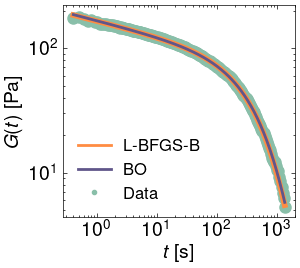

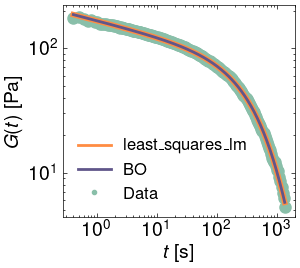

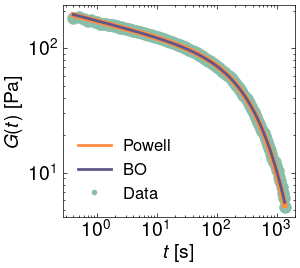

In [23]:
plot_best_fit('L-BFGS-B', results_spy, time, y_true, evaluator, bo_model_values)
plot_best_fit('least_squares_lm', results_spy, time, y_true, evaluator, bo_model_values)
plot_best_fit('Powell', results_spy, time, y_true, evaluator, bo_model_values)
